# Project: Wrangle & Analyze Data - WeRateDogs Twitter Account
##### by Jochen Zanker

## Introduction

Real-world data rarely comes clean. Using Python and its libraries, you are able to gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it.

The dataset in this project which will be wrangled (and analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy
import json
import re
import datetime as dt
%matplotlib inline

## Gathering

In [2]:
df = pd.read_csv("twitter-archive-enhanced.csv")
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
#Programmatically downloading the dog image prediction files using Request library
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

#Save tsv to file
with open('image_predictions.tsv', mode='wb') as file: file.write(response.content)

#Read in tsv file in pandas dataframe and quick check to view structure
image_predictions = pd.read_csv('image_predictions.tsv', sep='\t')
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [45]:
#Authentication Details: load personal API keys
consumer_key = 'mWMxupvHdNCdKkSRl289fZZiU'
consumer_secret = "fwOH5PnZ13fRA78dbvG0gKqMD2Rf2MJppzy3oAtzmnsbbMjc4s"
access_token = '934818650514690048-hwdq8iQ7L0axCtRov7KApwClQnGrlFu'
access_secret = 'oMQQeifBKqlUoibZRkr7OtJQD6pi5SubNOGg4f813Ezc2'

#Variables for Twitter API connection
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True)

In [46]:
#Add each tweet to a new line of tweet_json.txt
with open('tweet_json.txt', 'w', encoding='utf8') as f:
    for tweet_id in df['tweet_id']:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, f)
            f.write('\n')
        except:
            continue

In [47]:
#Add each tweet into a list
tweets_data = []
tweet_file = open('tweet_json.txt', 'r')

for line in tweet_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
            continue

            tweet_file.close()

In [48]:
#Create dataframe for tweet information
tweet_info = pd.DataFrame()

#Add variables to df: tweet ID, retweet count, favorite count
tweet_info['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets_data ))
tweet_info['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweet_info['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))

tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


## Assessing

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

There are 2356 entries. There are some missing values: 'in_reply_to_status_id' and 'in_reply_to_user_id' only have 78 entries. There are only 181 retweets ('retweeted_status_x'), but this is ok since we are interested in original tweets only and will remove these. Not all tweets have URLs; we don't have access to additional URLs, however we have another dataframe with photos.

In [50]:
df.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [51]:
df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [52]:
df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1313,706904523814649856,NaN,NaN,2016-03-07 18:09:06 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Ever seen a dog pet another dog? Both 13/10 truly an awe-inspiring scene. (Vid by @mdougherty20) https://t.co/3PoKf6cw7f,NaN,NaN,NaN,https://vine.co/v/iXQAm5Lrgrh,13,10,None,None,None,None,None
1149,726828223124897792,NaN,NaN,2016-05-01 17:38:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bloop. He's a Phoenician Winnebago. Tongue is just wow. That box is all he has (tragic). 12/10 would caress https://t.co/DWNrPPXgHA,NaN,NaN,NaN,https://twitter.com/dog_rates/status/726828223124897792/photo/1,12,10,Bloop,None,None,None,None
1793,677331501395156992,NaN,NaN,2015-12-17 03:36:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Humphrey. He's a Northern Polyp Viagra. One ear works. Face stuck like that. Always surprised. 9/10 petable af https://t.co/FS7eJQM2F4,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677331501395156992/photo/1,9,10,Humphrey,None,None,None,None
85,876120275196170240,NaN,NaN,2017-06-17 16:52:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https://t.co/ejExJFq3ek",NaN,NaN,NaN,https://twitter.com/dog_rates/status/876120275196170240/photo/1,13,10,Venti,None,None,None,None
662,790987426131050500,NaN,NaN,2016-10-25 18:44:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Misty. She has a cowboy hat on her nose. 12/10 https://t.co/Eno0mypHIr,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790987426131050500/photo/1,12,10,Misty,None,None,None,None


In [53]:
# View entire 'text' string to see if the URL is different from 'expande d_urls'
pd.set_option('display.max_colwidth', -1)
df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


Expanded_url's are the same, no need to extract 'https//x' from text.

In [54]:
df['name'].value_counts()

None         745
a            55 
Charlie      12 
Oliver       11 
Cooper       11 
Lucy         11 
Penny        10 
Lola         10 
Tucker       10 
Winston      9  
Bo           9  
Sadie        8  
the          8  
Buddy        7  
Bailey       7  
Toby         7  
an           7  
Daisy        7  
Rusty        6  
Dave         6  
Scout        6  
Bella        6  
Leo          6  
Jax          6  
Milo         6  
Stanley      6  
Jack         6  
Oscar        6  
Koda         6  
Sunny        5  
            ..  
Shooter      1  
Jackie       1  
Bowie        1  
Berkeley     1  
Einstein     1  
Rhino        1  
Norman       1  
Tom          1  
Mauve        1  
Brudge       1  
Theo         1  
Chase        1  
Snoopy       1  
Dixie        1  
Alejandro    1  
Biden        1  
Schnitzel    1  
Vinscent     1  
Kloey        1  
Harrison     1  
Vinnie       1  
Geno         1  
Bloop        1  
Darla        1  
Tino         1  
Jiminus      1  
Ole          1  
Richie       1

Not all entries appear to be the correct names nor are they in title case, will get cleaned after merging the datasets.

In [55]:
#View number of values in the source column
df['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [56]:
#Making sure all tweet-id's are unique
df.tweet_id.duplicated().sum()

0

In [57]:
#Numerical description
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [58]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


There are 2075 entries and no missing values.

In [59]:
image_predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
746,687664829264453632,https://pbs.twimg.com/media/CYsTg1XUsAEPjxE.jpg,1,pug,0.957365,True,French_bulldog,0.038559,True,toy_poodle,0.000667,True
993,708119489313951744,https://pbs.twimg.com/media/CdO-6x5W8AENSBJ.jpg,1,Norwich_terrier,0.264483,True,Norfolk_terrier,0.258786,True,chow,0.096899,True
959,705591895322394625,https://pbs.twimg.com/media/CcrEFQdUcAA7CJf.jpg,1,basenji,0.877207,True,Italian_greyhound,0.047854,True,miniature_pinscher,0.035638,True
535,676942428000112642,https://pbs.twimg.com/media/CWT7imQXIAMwpQ2.jpg,1,black-footed_ferret,0.707199,False,polecat,0.154630,False,weasel,0.097626,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True


In [60]:
#How many first predictions are actually dogs
image_predictions['p1_dog'].value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [61]:
#How many second predictions are not dogs
(image_predictions.p2_dog == False).sum()

522

In [62]:
#How many third predictions are not dogs
(image_predictions.p3_dog == False).sum()

576

In [63]:
#Find rows where p1, p2, p3 are all false
image_predictions[(image_predictions['p1_dog']==False) & (image_predictions['p2_dog']==False) & (image_predictions['p3_dog']==False)].count()
image_predictions[(image_predictions['p1_dog']==False) & (image_predictions['p2_dog']==False) & (image_predictions['p3_dog']==False)].sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
361,672828477930868736,https://pbs.twimg.com/media/CVZd7ttWcAEs2wP.jpg,1,sandbar,0.118154,False,stingray,0.075915,False,seashore,0.075125,False
1835,837012587749474308,https://pbs.twimg.com/media/C52pYJXWgAA2BEf.jpg,1,toilet_tissue,0.186387,False,cowboy_hat,0.158555,False,sombrero,0.149470,False
1142,729854734790754305,https://pbs.twimg.com/media/CiD3AfkXEAA3S_r.jpg,1,doormat,0.359586,False,china_cabinet,0.053901,False,passenger_car,0.052665,False
1134,728653952833728512,https://pbs.twimg.com/media/Chyy5lQWUAEzxSL.jpg,2,window_shade,0.594333,False,studio_couch,0.053515,False,rotisserie,0.041248,False
414,674008982932058114,https://pbs.twimg.com/media/CVqPkVoU4AAkXA7.jpg,1,jigsaw_puzzle,0.970810,False,prayer_rug,0.011048,False,quill,0.008432,False


In [64]:
#What kind of dogs are in the first prediction?
image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
malamute                     30 
cocker_spaniel               30 
French_bulldog               26 
Chesapeake_Bay_retriever     23 
miniature_pinscher           23 
seat_belt                    22 
Staffordshire_bullterrier    20 
German_shepherd              20 
Siberian_husky               20 
Cardigan                     19 
web_site                     19 
Eskimo_dog                   18 
teddy                        18 
beagle                       18 
Shetland_sheepdog            18 
Maltese_dog                  18 
Lakeland_terrier             17 
Shih-Tzu                     17 
Rottweiler                   17 
kuvasz                       16 
Italian_greyhound            16 
          

In [65]:
#Making sure all tweet-id's are unique
image_predictions.tweet_id.duplicated().sum()

0

In [66]:
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


There are 2340 entries and no missing values.

In [67]:
tweet_info.sample(5)

,tweet_id,retweet_count,favorite_count
1663,682047327939461121,1027,3343
856,761672994376806400,31240,52287
309,834574053763584002,2709,14313
947,750868782890057730,1481,5012
1028,743835915802583040,2211,0


In [68]:
#Making sure all id's are unique - no duplicates
print(sum(tweet_info.groupby('tweet_id')['tweet_id'].nunique()))
print(sum(tweet_info.tweet_id.duplicated()))

2340
0


#### Assessment Observations

Quality
- Remove unnecessary columns in all tables
- df, remove rows that are retweets (181 rows where retweeted_x have values)
- df, convert timestamp to datetime object
- df, update source column from url to text
- df, fix rating_numerator that are not extracted properly (those that have decimals)
- df, make all values in ratings_denominator '10' for consistency (or remove col)
- df, convert non-dog names to 'None' then make title case
- df, make names Title case
- df, check rating_numerator outliers - there are only 24 values over 15 (review manually)
- df, tweet_id datatype is an integer, convert to string (object)
- image_predictions, Remove non-dogs, the 324 rows where p1, p2, and p3 are false
- image_predictions, Update p1, p2, p3 to title text and remove underscores

Tidiness
- df, gather dog stages (doggo, puppo, pupper, floofer) into one column 'dog_stage'
- df, parse timestamp into separate columns: year, month, day, time (not necessary, keep timestamp column, but also want to view most popular days and months of tweets)
- image_predictions, create a 'prediction' column (Dog, Maybe Dog, Not Dog)
- Join tweet_info, df, and image_predictions into one master dataset on 'tweet_id'


## Cleaning

In [69]:
#Creating copies of original dataframes
archive_clean = df.copy()
image_clean = image_predictions.copy()
tweet_clean = tweet_info.copy()

In [70]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

***Define:*** Fix missing data in archive_clean. Remove rows with 'retweeted_status_x' since we are interested in original tweets only. Drop the 'in_reply_to_x' columns as these are unneccessary.

***Code:***

In [71]:
archive_clean.drop(archive_clean[archive_clean.retweeted_status_id.notnull()].index, inplace=True)
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

In [72]:
archive_clean.drop(['retweeted_status_id',
                    'retweeted_status_user_id',
                    'retweeted_status_timestamp',
                    'in_reply_to_status_id',
                    'in_reply_to_user_id'], axis=1, inplace=True)

***Test:***

In [73]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(3), object(9)
memory usage: 220.9+ KB


***Define:*** Combine dog stage columns (doggo, floofer, pupper, puppo) into one 'dog_stage' column. Delete the separate dog stage categories after visually inspecting a random sample to ensure the combination worked accurately. Convert entries in this column title case.

***Code:***

In [74]:
#Replace empty entries with a blank
archive_clean.doggo.replace('None', '', inplace=True)
archive_clean.floofer.replace('None', '', inplace=True)
archive_clean.pupper.replace('None', '', inplace=True)
archive_clean.puppo.replace('None', '', inplace=True)

#Create a new column for dog_stage
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo
archive_clean.dog_stage.value_counts()

                1831
pupper          224 
doggo           75  
puppo           24  
doggopupper     10  
floofer         9   
doggopuppo      1   
doggofloofer    1   
Name: dog_stage, dtype: int64

In [75]:
#Test to make sure dog_stage is accurate
archive_clean[['doggo', 'floofer', 'pupper', 'puppo', 'dog_stage']].sample(10)

,doggo,floofer,pupper,puppo,dog_stage
426,doggo,,,,doggo
458,,,,,
1185,,,,,
136,,,,,
2176,,,,,
2308,,,,,
1545,,,,,
1701,,,,,
2223,,,,,
1484,,,,,


In [76]:
#Rename values in dog_stage column
archive_clean.loc[archive_clean.dog_stage == 'pupper', 'dog_stage'] = 'Pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggo', 'dog_stage'] = 'Doggo'
archive_clean.loc[archive_clean.dog_stage == 'puppo', 'dog_stage'] = 'Puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'Doggo, Pupper'
archive_clean.loc[archive_clean.dog_stage == 'floofer', 'dog_stage'] ='Floofer'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'Doggo, Puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'Doggo, Floofer'

#Replace blank cells with NaNs
archive_clean.loc[archive_clean.dog_stage == '', 'dog_stage'] = np.nan

#Replace NaNs with text so we have non-null values
archive_clean.dog_stage = archive_clean.dog_stage.fillna('Unknown')
archive_clean.dog_stage.value_counts()

Unknown           1831
Pupper            224 
Doggo             75  
Puppo             24  
Doggo, Pupper     10  
Floofer           9   
Doggo, Floofer    1   
Doggo, Puppo      1   
Name: dog_stage, dtype: int64

In [77]:
#Drop unnecessary columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

***Test:***

In [78]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null object
dtypes: int64(3), object(6)
memory usage: 169.9+ KB


In [79]:
archive_clean.dog_stage.sample(5)

1129    Unknown
1226    Unknown
45      Unknown
1431    Unknown
576     Doggo  
Name: dog_stage, dtype: object

***Define:*** Replace 4 source links with text string defining the link.

In [80]:
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     31  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [81]:
#Text replacements
source_txt = {'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>': 'Twitter for iPhone',
              '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'Vine - Make a Scene',
              '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'Twitter Web Client',
              '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'TweetDeck'}

#Apply function
def text_source(archive_clean):
    if archive_clean['source'] in source_txt.keys():
        abbrev = source_txt[archive_clean['source']]
        return abbrev 
    else:
        return archive_clean['source']

archive_clean['source'] = archive_clean.apply(text_source, axis=1)

***Test:***

In [82]:
archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

***Define:*** Combine tweet_clean and archive_clean, via inner join (default) on 'tweet_id'.

In [83]:
tweet_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
tweet_id          2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


***Code:***

In [84]:
twitter_archive_master = pd.merge(archive_clean, tweet_clean, on='tweet_id', how = 'inner')

***Test:***

In [85]:
#Ensure that the new master includes columns from both archive_clean and tweet_clean
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2172
Data columns (total 11 columns):
tweet_id              2173 non-null int64
timestamp             2173 non-null object
source                2173 non-null object
text                  2173 non-null object
expanded_urls         2115 non-null object
rating_numerator      2173 non-null int64
rating_denominator    2173 non-null int64
name                  2173 non-null object
dog_stage             2173 non-null object
retweet_count         2173 non-null int64
favorite_count        2173 non-null int64
dtypes: int64(5), object(6)
memory usage: 203.7+ KB


***Define:*** Convert timestamp to datetime and spread into 4 columns for year, month, day, and time. Keep the timestamp (datetime) column for visualizations.

***Code:***

In [86]:
from datetime import date

#Convert timestamp to datetime
twitter_archive_master['timestamp'] = pd.to_datetime(twitter_archive_master['timestamp'])

#Extract datetime to new year, month, day, time columns
twitter_archive_master['year'] = twitter_archive_master['timestamp'].dt.year
twitter_archive_master['month'] = twitter_archive_master['timestamp'].dt.month
twitter_archive_master['day'] = twitter_archive_master['timestamp'].dt.day
twitter_archive_master['time'] = twitter_archive_master['timestamp'].dt.time

#Create day of week column
twitter_archive_master['weekday'] = twitter_archive_master['timestamp'].dt.dayofweek
days = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
twitter_archive_master['weekday'] = twitter_archive_master['weekday'].apply(lambda x: days[x])

twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2172
Data columns (total 16 columns):
tweet_id              2173 non-null int64
timestamp             2173 non-null datetime64[ns]
source                2173 non-null object
text                  2173 non-null object
expanded_urls         2115 non-null object
rating_numerator      2173 non-null int64
rating_denominator    2173 non-null int64
name                  2173 non-null object
dog_stage             2173 non-null object
retweet_count         2173 non-null int64
favorite_count        2173 non-null int64
year                  2173 non-null int64
month                 2173 non-null int64
day                   2173 non-null int64
time                  2173 non-null object
weekday               2173 non-null object
dtypes: datetime64[ns](1), int64(8), object(7)
memory usage: 288.6+ KB


***Test:***

In [87]:
twitter_archive_master['weekday'].value_counts()

Mon      357
Tues     326
Weds     322
Thurs    304
Fri      304
Sat      284
Sun      276
Name: weekday, dtype: int64

***Define:*** Create a new column for the dog prediction summary in image_prediction:
- When all three predictions are true, insert text 'Dog'
- When all three predictions are false, insert text 'Not Dog'
- When 1 or 2 precictions are true, insert text 'Maybe Dog'

***Code:***

In [88]:
#Convert p1_dog, p2_dog, p3_dog to an integer (True=1, False=0)
prediction_summary = ['p1_dog', 'p2_dog', 'p3_dog']

for p in prediction_summary:
    image_clean[p] = image_clean[p].astype(int)

#Create a new column that adds the total number of True and False for the 3 predictions
image_clean['prediction'] = image_clean.p1_dog + image_clean.p2_dog + image_clean.p3_dog

#Replace the number with a defining text string
image_clean['prediction'] = image_clean['prediction'].replace(3, 'Dog')
image_clean['prediction'] = image_clean['prediction'].replace(2, 'Maybe Dog')
image_clean['prediction'] = image_clean['prediction'].replace(1, 'Maybe Dog')
image_clean['prediction'] = image_clean['prediction'].replace(0, 'Not Dog')

***Test:***

In [89]:
image_clean[['p1_dog', 'p2_dog', 'p3_dog','prediction']].sample(10)

,p1_dog,p2_dog,p3_dog,prediction
1906,0,0,0,Not Dog
1741,1,1,1,Dog
1359,1,1,1,Dog
725,1,1,1,Dog
1655,1,1,1,Dog
586,0,0,1,Maybe Dog
675,1,1,1,Dog
1617,0,0,0,Not Dog
230,0,0,0,Not Dog
414,0,0,0,Not Dog


In [90]:
image_clean.prediction.value_counts()

Dog          1243
Maybe Dog    508 
Not Dog      324 
Name: prediction, dtype: int64

***Define:*** Now we can drop the extraneous p1_dog, p2_dog, and p3_dog columns for simplicity, along with image_num.

***Code:***

In [91]:
image_clean.drop(['p1_dog', 'p2_dog', 'p3_dog', 'img_num'], axis=1, inplace=True)

***Test:***

In [92]:
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 9 columns):
tweet_id      2075 non-null int64
jpg_url       2075 non-null object
p1            2075 non-null object
p1_conf       2075 non-null float64
p2            2075 non-null object
p2_conf       2075 non-null float64
p3            2075 non-null object
p3_conf       2075 non-null float64
prediction    2075 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 146.0+ KB


***Define:*** Join image_clean to twitter_archive_master

***Code:***

In [93]:
twitter_archive_master = pd.merge(twitter_archive_master, image_clean, on='tweet_id')

***Test:***

In [94]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 24 columns):
tweet_id              1992 non-null int64
timestamp             1992 non-null datetime64[ns]
source                1992 non-null object
text                  1992 non-null object
expanded_urls         1992 non-null object
rating_numerator      1992 non-null int64
rating_denominator    1992 non-null int64
name                  1992 non-null object
dog_stage             1992 non-null object
retweet_count         1992 non-null int64
favorite_count        1992 non-null int64
year                  1992 non-null int64
month                 1992 non-null int64
day                   1992 non-null int64
time                  1992 non-null object
weekday               1992 non-null object
jpg_url               1992 non-null object
p1                    1992 non-null object
p1_conf               1992 non-null float64
p2                    1992 non-null object
p2_conf               1992 non-n

In [95]:
twitter_archive_master.prediction.value_counts()

Dog          1201
Maybe Dog    483 
Not Dog      308 
Name: prediction, dtype: int64

We now have one combined dataset with 1992 entries and a full set of values.

In [96]:
twitter_archive_master.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,time,weekday,jpg_url,p1,p1_conf,p2,p2_conf,p3,p3_conf,prediction
1964,666396247373291520,2015-11-16 23:23:41,Twitter for iPhone,Oh goodness. A super rare northeast Qdoba kangaroo mix. Massive feet. No pouch (disappointing). Seems alert. 9/10 https://t.co/Dc7b0E8qFE,https://twitter.com/dog_rates/status/666396247373291520/photo/1,9,10,None,Unknown,83,...,23:23:41,Mon,https://pbs.twimg.com/media/CT-D2ZHWIAA3gK1.jpg,Chihuahua,0.978108,toy_terrier,0.009397,papillon,0.004577,Dog
7,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,Unknown,18359,...,00:22:40,Fri,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,Pomeranian,0.566142,Eskimo_dog,0.178406,Pembroke,0.076507,Dog
1484,676101918813499392,2015-12-13 18:10:33,Twitter for iPhone,Meet Striker. He's ready for Christmas. 11/10 https://t.co/B3xxSLjQSH,https://twitter.com/dog_rates/status/676101918813499392/photo/1,11,10,Striker,Unknown,1211,...,18:10:33,Sun,https://pbs.twimg.com/media/CWH_FTgWIAAwOUy.jpg,Shih-Tzu,0.225848,Norfolk_terrier,0.186873,Irish_terrier,0.106987,Dog


***Define:*** We could change the denominator rating to 10 for all entries, but it makes more sense to drop this column and rename the rating_numerator to rating for simplicity.


***Code:***

In [97]:
#twitter_archive_master['rating_denominator'] = 10
twitter_archive_master.drop(['rating_denominator'], axis=1, inplace=True )
twitter_archive_master.rename(columns={'rating_numerator': 'rating'}, inplace=True)

***Test:***

In [98]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 23 columns):
tweet_id          1992 non-null int64
timestamp         1992 non-null datetime64[ns]
source            1992 non-null object
text              1992 non-null object
expanded_urls     1992 non-null object
rating            1992 non-null int64
name              1992 non-null object
dog_stage         1992 non-null object
retweet_count     1992 non-null int64
favorite_count    1992 non-null int64
year              1992 non-null int64
month             1992 non-null int64
day               1992 non-null int64
time              1992 non-null object
weekday           1992 non-null object
jpg_url           1992 non-null object
p1                1992 non-null object
p1_conf           1992 non-null float64
p2                1992 non-null object
p2_conf           1992 non-null float64
p3                1992 non-null object
p3_conf           1992 non-null float64
prediction        1992 non-null

***Define:*** Clean 'name' column. Convert non-names to 'None'.

***Code:***

In [99]:
twitter_archive_master['name'].value_counts()
twitter_archive_master['name'].str.lower()

0       phineas 
1       tilly   
2       archie  
3       darla   
4       franklin
5       none    
6       jax     
7       none    
8       zoey    
9       cassie  
10      koda    
11      bruno   
12      none    
13      ted     
14      stuart  
15      oliver  
16      jim     
17      zeke    
18      ralphus 
19      gerald  
20      jeffrey 
21      such    
22      canela  
23      none    
24      none    
25      maya    
26      mingus  
27      derek   
28      roscoe  
29      waffles 
         ...    
1962    quite   
1963    a       
1964    none    
1965    none    
1966    none    
1967    none    
1968    none    
1969    an      
1970    a       
1971    an      
1972    none    
1973    none    
1974    none    
1975    none    
1976    none    
1977    none    
1978    none    
1979    none    
1980    none    
1981    the     
1982    the     
1983    a       
1984    a       
1985    an      
1986    a       
1987    none    
1988    a       
1989    a     

In [100]:
wrong_name = twitter_archive_master.name.str.islower()
twitter_archive_master.loc[wrong_name, 'name'] = 'None'

#Convert names to title case
twitter_archive_master.name = twitter_archive_master.name.str.title()

***Test:***

In [101]:
twitter_archive_master['name'].value_counts()

None         644
Charlie      10 
Oliver       10 
Cooper       10 
Lucy         10 
Penny        9  
Tucker       9  
Sadie        8  
Winston      8  
Toby         7  
Daisy        7  
Lola         7  
Koda         6  
Jax          6  
Bo           6  
Bella        6  
Stanley      6  
Buddy        5  
Leo          5  
Dave         5  
Milo         5  
Scout        5  
Rusty        5  
Louis        5  
Chester      5  
Bailey       5  
Oscar        5  
Bentley      4  
Oakley       4  
Dexter       4  
            ..  
Harper       1  
Coleman      1  
Dixie        1  
Alejandro    1  
Dido         1  
Biden        1  
Kaia         1  
Schnitzel    1  
Horace       1  
Dex          1  
Leonidas     1  
Harry        1  
Ralphie      1  
Kyro         1  
Ralpher      1  
Ozzy         1  
Emmy         1  
Karma        1  
Bobb         1  
Jersey       1  
Derby        1  
Zoe          1  
Chompsky     1  
Jazz         1  
Bruno        1  
Millie       1  
Kota         1  
Kayla        1

***Define:*** For all predictions (p1, p2, p3), remove underscores.

***Code:***

In [102]:
predictions = ['p1', 'p2', 'p3']
for p in predictions:
    twitter_archive_master[p] = twitter_archive_master[p].str.title().str.replace('_', " ")

***Test:***

In [103]:
twitter_archive_master[['p1', 'p2', 'p3']].sample(10)

,p1,p2,p3
1100,Golden Retriever,Kuvasz,Labrador Retriever
195,Washer,Dishwasher,Printer
1318,Italian Greyhound,Whippet,German Short-Haired Pointer
1208,Pug,French Bulldog,Brabancon Griffon
1894,West Highland White Terrier,Pug,Ice Bear
1424,Miniature Pinscher,Kelpie,Vizsla
620,Golden Retriever,Labrador Retriever,Border Terrier
11,French Bulldog,Labrador Retriever,Muzzle
1113,Brittany Spaniel,Welsh Springer Spaniel,Beagle
402,Arabian Camel,House Finch,Cocker Spaniel


***Define:*** Convert confidence levels to a percentage by multiplying by 100, converting the float to an integer, and displaying only 2 numbers.


***Code:***

In [104]:
confidence = ['p1_conf', 'p2_conf', 'p3_conf']
for c in confidence:
    twitter_archive_master[c] = round(twitter_archive_master[c]*100).astype(int)

***Test:***

In [105]:
twitter_archive_master[['p1_conf', 'p2_conf', 'p3_conf']].sample(5)

,p1_conf,p2_conf,p3_conf
236,33,20,7
1279,92,1,1
1500,72,6,4
1976,58,17,9
922,62,12,7


In [106]:
twitter_archive_master.prediction.value_counts()

Dog          1201
Maybe Dog    483 
Not Dog      308 
Name: prediction, dtype: int64

In [107]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1992 entries, 0 to 1991
Data columns (total 23 columns):
tweet_id          1992 non-null int64
timestamp         1992 non-null datetime64[ns]
source            1992 non-null object
text              1992 non-null object
expanded_urls     1992 non-null object
rating            1992 non-null int64
name              1992 non-null object
dog_stage         1992 non-null object
retweet_count     1992 non-null int64
favorite_count    1992 non-null int64
year              1992 non-null int64
month             1992 non-null int64
day               1992 non-null int64
time              1992 non-null object
weekday           1992 non-null object
jpg_url           1992 non-null object
p1                1992 non-null object
p1_conf           1992 non-null int64
p2                1992 non-null object
p2_conf           1992 non-null int64
p3                1992 non-null object
p3_conf           1992 non-null int64
prediction        1992 non-null objec

***Define:*** Remove non-dogs from master dataset.

***Code:***

In [108]:
twitter_archive_master = twitter_archive_master[twitter_archive_master['prediction'] != "Not Dog"]

***Test:***

In [109]:
twitter_archive_master.prediction.value_counts()

Dog          1201
Maybe Dog    483 
Name: prediction, dtype: int64

In [110]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1684 entries, 1 to 1991
Data columns (total 23 columns):
tweet_id          1684 non-null int64
timestamp         1684 non-null datetime64[ns]
source            1684 non-null object
text              1684 non-null object
expanded_urls     1684 non-null object
rating            1684 non-null int64
name              1684 non-null object
dog_stage         1684 non-null object
retweet_count     1684 non-null int64
favorite_count    1684 non-null int64
year              1684 non-null int64
month             1684 non-null int64
day               1684 non-null int64
time              1684 non-null object
weekday           1684 non-null object
jpg_url           1684 non-null object
p1                1684 non-null object
p1_conf           1684 non-null int64
p2                1684 non-null object
p2_conf           1684 non-null int64
p3                1684 non-null object
p3_conf           1684 non-null int64
prediction        1684 non-null objec

In [111]:
twitter_archive_master.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,p1,p1_conf,p2,p2_conf,p3,p3_conf,prediction
1030,706166467411222528,2016-03-05 17:16:20,Twitter for iPhone,This is Dexter. He's a shy pup. Doesn't bark much. Dreadful fetcher. Has rare sun allergy. 7/10 still petable https://t.co/sA7P3JSqiv,https://twitter.com/dog_rates/status/706166467411222528/photo/1,7,Dexter,Unknown,1703,5360,...,17:16:20,Sat,https://pbs.twimg.com/media/CczOp_OWoAAo5zR.jpg,Samoyed,43,Kuvasz,28,Great Pyrenees,12,Dog
1516,675166823650848770,2015-12-11 04:14:49,Twitter for iPhone,This is Arnold. He broke his leg saving a handicapped child from a forest fire. True hero. 10/10 inspirational dog https://t.co/bijCeHeX4C,https://twitter.com/dog_rates/status/675166823650848770/photo/1,10,Arnold,Unknown,1674,3699,...,04:14:49,Fri,https://pbs.twimg.com/media/CV6spB7XAAIpMyP.jpg,Llama,28,Standard Poodle,13,Teddy,13,Maybe Dog
1772,670093938074779648,2015-11-27 04:16:59,Twitter for iPhone,This is Wally. He's a Flaccid Mitochondria. Going on vacation. Bag definitely full of treats. Great hat. 9/10 https://t.co/vYs9IVzHY9,https://twitter.com/dog_rates/status/670093938074779648/photo/1,9,Wally,Unknown,342,1039,...,04:16:59,Fri,https://pbs.twimg.com/media/CUym4Y5WsAEiI9_.jpg,Toy Poodle,38,Miniature Poodle,15,Chow,14,Dog


***Define:*** Rename p1, p2, p2 with more obvious names.

In [112]:
twitter_archive_master.rename(columns={'p1': 'prediction_1',
                                      'p2': 'prediction_2',
                                        'p3': 'prediction_3'}, inplace=True)

***Test:***

In [113]:
twitter_archive_master[['prediction_1', 'prediction_2', 'prediction_3']].sample(10)

,prediction_1,prediction_2,prediction_3
309,Lakeland Terrier,Labrador Retriever,Irish Terrier
72,Labrador Retriever,Chesapeake Bay Retriever,Vizsla
1157,Boxer,Bull Mastiff,Saint Bernard
276,Teddy,Toy Poodle,Standard Poodle
841,Koala,Staffordshire Bullterrier,Mongoose
220,Golden Retriever,Labrador Retriever,Kuvasz
366,Golden Retriever,Labrador Retriever,Saluki
479,Miniature Pinscher,Toy Terrier,Doberman
1038,Chihuahua,Quilt,Pembroke
482,Bernese Mountain Dog,Entlebucher,Appenzeller


***Define:*** Convert tweet_id from an integer to a string (object) since we are not intending to perform math calculations with this data.

***Code:***

In [114]:
twitter_archive_master['tweet_id'] = twitter_archive_master['tweet_id'].astype(str)

***Test:***

In [115]:
twitter_archive_master['tweet_id'].describe()

count     1684              
unique    1684              
top       666094000022159362
freq      1                 
Name: tweet_id, dtype: object

***Define:*** Investigate numerators that might be inaccurate by extracting decimals.

***Code:***

In [116]:
#twitter_archive_master['rating'].astype(float)
twitter_archive_master['rating'] = twitter_archive_master.text.str.extract('(\d[.,]?\d+)')
twitter_archive_master['rating'].unique()

array(['13', '12', '14', '11', '10', '236', '60', '84', '24', '98',
       '9.75', '46', '100', '165', '50', '17', '2002', '2.0', '47', '20',
       '99', '80', '45', '400', '44', '31', '33', '97', '61', '143',
       '121', '260', '2015', '92', '144', '88', '85', '8.98', '1949'],
      dtype=object)

In [117]:
#Locate tweed_ids for the suspect numerators
twitter_archive_master[(twitter_archive_master['rating'] == '9.75') |
                       (twitter_archive_master['rating'] == '2.0') |
                       (twitter_archive_master['rating'] == '8.98') |
                       (twitter_archive_master['rating'] == '165') |
                       (twitter_archive_master['rating'] == '260') |
                       (twitter_archive_master['rating'] == '2015') |
                       (twitter_archive_master['rating'] == '2002') |
                       (twitter_archive_master['rating'] == '1949')]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
503,786709082849828864,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,Logan,Unknown,6642,19359,...,23:23:56,Thurs,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Pomeranian,47,Persian Cat,12,Chow,10,Maybe Dog
662,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,None,Unknown,2392,5060,...,01:00:57,Thurs,https://pbs.twimg.com/ext_tw_video_thumb/758467147756691456/pu/img/YTNzjRFDSPNXukmM.jpg,Labrador Retriever,44,Chihuahua,11,American Staffordshire Terrier,10,Dog
718,750086836815486976,2016-07-04 22:00:12,TweetDeck,This is Spanky. He was a member of the 2002 USA Winter Olympic speed skating team. Accomplished af. 12/10 https://t.co/7tlZPrePXd,https://twitter.com/dog_rates/status/750086836815486976/photo/1,2002,Spanky,Unknown,581,2279,...,22:00:12,Mon,https://pbs.twimg.com/media/Cmf5WLGWYAAcmRw.jpg,Pug,98,Teddy,0,Brabancon Griffon,0,Maybe Dog
757,746818907684614144,2016-06-25 21:34:37,Twitter for iPhone,Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ,https://twitter.com/dog_rates/status/746818907684614144/photo/1,2.0,None,Unknown,1836,5552,...,21:34:37,Sat,https://pbs.twimg.com/media/Cl071YVWEAAlF7N.jpg,Dingo,18,Timber Wolf,13,Ibizan Hound,10,Maybe Dog
1314,683773439333797890,2016-01-03 22:14:26,Twitter for iPhone,This is Buddy. He's gaining strength. Currently an F4 tornado with wind speeds up to 260mph. Very devastating. 9/10 https://t.co/qipZbshNsR,https://twitter.com/dog_rates/status/683773439333797890/photo/1,260,Buddy,Unknown,1442,3491,...,22:14:26,Sun,https://pbs.twimg.com/media/CX1AUQ2UAAAC6s-.jpg,Miniature Pinscher,7,Labrador Retriever,6,Schipperke,5,Dog
1326,683030066213818368,2016-01-01 21:00:32,Twitter for iPhone,This is Lulu. She's contemplating all her unreached 2015 goals and daydreaming of a more efficient tomorrow. 10/10 https://t.co/h3ScYuz77J,https://twitter.com/dog_rates/status/683030066213818368/photo/1,2015,Lulu,Unknown,773,2245,...,21:00:32,Fri,https://pbs.twimg.com/media/CXqcOHCUQAAugTB.jpg,Boxer,72,Bull Mastiff,19,French Bulldog,6,Dog
1331,682662431982772225,2015-12-31 20:39:41,Twitter for iPhone,Meet Joey and Izzy. Joey only has one ear that works and Izzy wants 2015 to be over already. Both great pups. 11/10s https://t.co/WgQTIQ93BB,https://twitter.com/dog_rates/status/682662431982772225/photo/1,2015,Joey,Unknown,1150,3179,...,20:39:41,Thurs,https://pbs.twimg.com/media/CXlN1-EWMAQdwXK.jpg,Beagle,41,Cardigan,26,Basset,17,Dog
1983,666057090499244032,2015-11-16 00:55:59,Twitter for iPhone,My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,https://twitter.com/dog_rates/status/666057090499244032/photo/1,8.98,None,Unknown,138,289,...,00:55:59,Mon,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,Shopping Cart,96,Shopping Basket,1,Golden Retriever,1,Maybe Dog
1987,666049248165822465,2015-11-16 00:24:50,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,1949,None,Unknown,42,106,...,00:24:50,Mon,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature Pinscher,56,Rottweiler,24,Doberman,15,Dog


In [118]:
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '786709082849828864', 'rating'] = 10
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '746818907684614144', 'rating'] = 13
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '666057090499244032', 'rating'] = 9
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '683773439333797890', 'rating'] = 9
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '683030066213818368', 'rating'] = 10
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '682662431982772225', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '666049248165822465', 'rating'] = 5
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '750086836815486976', 'rating'] = 12
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '758467244762497024', 'rating'] = 11

***Test:***

In [119]:
twitter_archive_master[(twitter_archive_master['tweet_id'] == '786709082849828864') |
                       (twitter_archive_master['tweet_id'] == '746818907684614144') |
                       (twitter_archive_master['tweet_id'] == '666057090499244032') |
                       (twitter_archive_master['tweet_id'] == '683773439333797890') |
                       (twitter_archive_master['tweet_id'] == '683030066213818368') |
                       (twitter_archive_master['tweet_id'] == '682662431982772225') |
                       (twitter_archive_master['tweet_id'] == '666049248165822465') |
                       (twitter_archive_master['tweet_id'] == '758467244762497024') |
                       (twitter_archive_master['tweet_id'] == '750086836815486976')]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
503,786709082849828864,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,10,Logan,Unknown,6642,19359,...,23:23:56,Thurs,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,Pomeranian,47,Persian Cat,12,Chow,10,Maybe Dog
662,758467244762497024,2016-07-28 01:00:57,Twitter for iPhone,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,11,None,Unknown,2392,5060,...,01:00:57,Thurs,https://pbs.twimg.com/ext_tw_video_thumb/758467147756691456/pu/img/YTNzjRFDSPNXukmM.jpg,Labrador Retriever,44,Chihuahua,11,American Staffordshire Terrier,10,Dog
718,750086836815486976,2016-07-04 22:00:12,TweetDeck,This is Spanky. He was a member of the 2002 USA Winter Olympic speed skating team. Accomplished af. 12/10 https://t.co/7tlZPrePXd,https://twitter.com/dog_rates/status/750086836815486976/photo/1,12,Spanky,Unknown,581,2279,...,22:00:12,Mon,https://pbs.twimg.com/media/Cmf5WLGWYAAcmRw.jpg,Pug,98,Teddy,0,Brabancon Griffon,0,Maybe Dog
757,746818907684614144,2016-06-25 21:34:37,Twitter for iPhone,Guys... Dog Jesus 2.0\n13/10 buoyant af https://t.co/CuNA7OwfKQ,https://twitter.com/dog_rates/status/746818907684614144/photo/1,13,None,Unknown,1836,5552,...,21:34:37,Sat,https://pbs.twimg.com/media/Cl071YVWEAAlF7N.jpg,Dingo,18,Timber Wolf,13,Ibizan Hound,10,Maybe Dog
1314,683773439333797890,2016-01-03 22:14:26,Twitter for iPhone,This is Buddy. He's gaining strength. Currently an F4 tornado with wind speeds up to 260mph. Very devastating. 9/10 https://t.co/qipZbshNsR,https://twitter.com/dog_rates/status/683773439333797890/photo/1,9,Buddy,Unknown,1442,3491,...,22:14:26,Sun,https://pbs.twimg.com/media/CX1AUQ2UAAAC6s-.jpg,Miniature Pinscher,7,Labrador Retriever,6,Schipperke,5,Dog
1326,683030066213818368,2016-01-01 21:00:32,Twitter for iPhone,This is Lulu. She's contemplating all her unreached 2015 goals and daydreaming of a more efficient tomorrow. 10/10 https://t.co/h3ScYuz77J,https://twitter.com/dog_rates/status/683030066213818368/photo/1,10,Lulu,Unknown,773,2245,...,21:00:32,Fri,https://pbs.twimg.com/media/CXqcOHCUQAAugTB.jpg,Boxer,72,Bull Mastiff,19,French Bulldog,6,Dog
1331,682662431982772225,2015-12-31 20:39:41,Twitter for iPhone,Meet Joey and Izzy. Joey only has one ear that works and Izzy wants 2015 to be over already. Both great pups. 11/10s https://t.co/WgQTIQ93BB,https://twitter.com/dog_rates/status/682662431982772225/photo/1,11,Joey,Unknown,1150,3179,...,20:39:41,Thurs,https://pbs.twimg.com/media/CXlN1-EWMAQdwXK.jpg,Beagle,41,Cardigan,26,Basset,17,Dog
1983,666057090499244032,2015-11-16 00:55:59,Twitter for iPhone,My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,https://twitter.com/dog_rates/status/666057090499244032/photo/1,9,None,Unknown,138,289,...,00:55:59,Mon,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,Shopping Cart,96,Shopping Basket,1,Golden Retriever,1,Maybe Dog
1987,666049248165822465,2015-11-16 00:24:50,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,None,Unknown,42,106,...,00:24:50,Mon,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature Pinscher,56,Rottweiler,24,Doberman,15,Dog


In [120]:
#Convert rating to float
twitter_archive_master['rating'] = twitter_archive_master['rating'].astype(float)

***Define:*** Remove outliers by investigating all ratings that are above 14.

In [121]:
twitter_archive_master['rating'].sort_values(ascending=False).head(15)

996     400.0
192     236.0
1433    144.0
1301    143.0
1302    121.0
614     100.0
1820    100.0
945     99.0 
448     98.0 
1269    97.0 
1424    92.0 
1492    88.0 
1563    85.0 
323     84.0 
969     80.0 
Name: rating, dtype: float64

In [122]:
#Looking for other suspect ratings
twitter_archive_master[(twitter_archive_master['rating'] == 400.0) |
                       (twitter_archive_master['rating'] == 236.0) |
                       (twitter_archive_master['rating'] == 144.0) |
                       (twitter_archive_master['rating'] == 143.0) |
                       (twitter_archive_master['rating'] == 121.0) |
                       (twitter_archive_master['rating'] == 100.0) |
                       (twitter_archive_master['rating'] == 99.0) |
                       (twitter_archive_master['rating'] == 98.0) |
                       (twitter_archive_master['rating'] == 97.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
192,844979544864018432,2017-03-23 18:29:57,Twitter for iPhone,"PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby https://t.co/a5OaJeRl9B","https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1,https://twitter.com/dog_rates/status/844979544864018432/photo/1",236.0,None,Unknown,2721,14101,...,18:29:57,Thurs,https://pbs.twimg.com/media/C7n4aQ0VAAAohkL.jpg,Tennis Ball,100,Racket,0,Shetland Sheepdog,0,Maybe Dog
448,796080075804475393,2016-11-08 20:00:55,Twitter for iPhone,This is Yogi. He's 98% floof. Snuggable af. 12/10 https://t.co/opoXKxmfFm,https://twitter.com/dog_rates/status/796080075804475393/photo/1,98.0,Yogi,Unknown,2534,9028,...,20:00:55,Tues,https://pbs.twimg.com/media/Cww-msrXcAAxm3K.jpg,Chow,97,Tibetan Mastiff,1,Gibbon,0,Maybe Dog
614,766793450729734144,2016-08-20 00:26:19,Twitter for iPhone,This is Rufus. He just missed out on the 100m final at Rio. Already training hard for Tokyo. 10/10 never give pup https://t.co/exrRjjJqeO,https://twitter.com/dog_rates/status/766793450729734144/photo/1,100.0,Rufus,Unknown,1465,5358,...,00:26:19,Sat,https://pbs.twimg.com/media/CqQykxrWYAAlD8g.jpg,Beagle,45,Basset,20,Bloodhound,7,Dog
945,713900603437621249,2016-03-27 01:29:02,Twitter for iPhone,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99.0,None,Unknown,779,2949,...,01:29:02,Sun,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,Golden Retriever,37,Cocker Spaniel,18,Irish Setter,9,Dog
996,708469915515297792,2016-03-12 01:49:25,Twitter for iPhone,This is Bobble. He's a Croatian Galifianakis. Hears everything within 400 miles. 11/10 would snug diligently https://t.co/VwDc6PTDzk,https://twitter.com/dog_rates/status/708469915515297792/photo/1,400.0,Bobble,Unknown,865,3212,...,01:49:25,Sat,https://pbs.twimg.com/media/CdT9n7mW0AQcpZU.jpg,Chihuahua,75,Toy Terrier,13,Pembroke,4,Dog
1269,686050296934563840,2016-01-10 05:01:51,Twitter for iPhone,This is Flávio. He's a Macedonian Poppycock. 97% floof. Jubilant af. 11/10 personally I'd pet the hell out of https://t.co/BUyX7isHRg,https://twitter.com/dog_rates/status/686050296934563840/photo/1,97.0,Flávio,Unknown,776,2304,...,05:01:51,Sun,https://pbs.twimg.com/media/CYVXBb9WsAAwL3p.jpg,Pomeranian,99,Keeshond,0,Pekinese,0,Dog
1301,684225744407494656,2016-01-05 04:11:44,Twitter for iPhone,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3","https://twitter.com/dog_rates/status/684225744407494656/photo/1,https://twitter.com/dog_rates/status/684225744407494656/photo/1",143.0,None,Unknown,227,1288,...,04:11:44,Tues,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,Golden Retriever,20,Samoyed,7,Great Pyrenees,7,Dog
1302,684222868335505415,2016-01-05 04:00:18,Twitter for iPhone,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,https://twitter.com/dog_rates/status/684222868335505415/photo/1,121.0,None,Unknown,1463,4001,...,04:00:18,Tues,https://pbs.twimg.com/media/CX7Y_ByWwAEJdUy.jpg,Soft-Coated Wheaten Terrier,79,Cocker Spaniel,7,Teddy,7,Maybe Dog
1433,677716515794329600,2015-12-18 05:06:23,Twitter for iPhone,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,https://twitter.com/dog_rates/status/677716515794329600/photo/1,144.0,None,Unknown,1018,3161,...,05:06:23,Fri,https://pbs.twimg.com/media/CWe7kw9W4AE8UJh.jpg,Teddy,66,Crib,3,Chow,3,Maybe Dog
1820,669006782128353280,2015-11-24 04:17:01,Twitter for iPhone,This is Tucker. He is 100% ready for the sports. 12/10 I would watch anyth

***Code:***

In [123]:
#Fixing
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '844979544864018432', 'rating'] = 13
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '844979544864018432', 'rating'] = 12
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '766793450729734144', 'rating'] = 10
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '713900603437621249', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '708469915515297792', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '686050296934563840', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '684225744407494656', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '684222868335505415', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '677716515794329600', 'rating'] = 12
twitter_archive_master.loc[twitter_archive_master['tweet_id'] == '669006782128353280', 'rating'] = 12

In [124]:
twitter_archive_master['rating'].sort_values(ascending=False).head(5)

448     98.0
1424    92.0
1492    88.0
1563    85.0
323     84.0
Name: rating, dtype: float64

In [125]:
#Inspect additional 5
twitter_archive_master[(twitter_archive_master['rating'] == 98.0) |
                       (twitter_archive_master['rating'] == 92.0) |
                       (twitter_archive_master['rating'] == 88.0) |
                       (twitter_archive_master['rating'] == 85.0) |
                       (twitter_archive_master['rating'] == 84.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
323,820690176645140481,2017-01-15 17:52:40,Twitter for iPhone,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84.0,None,Unknown,3490,12907,...,17:52:40,Sun,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,West Highland White Terrier,87,Kuvasz,6,Samoyed,4,Dog
448,796080075804475393,2016-11-08 20:00:55,Twitter for iPhone,This is Yogi. He's 98% floof. Snuggable af. 12/10 https://t.co/opoXKxmfFm,https://twitter.com/dog_rates/status/796080075804475393/photo/1,98.0,Yogi,Unknown,2534,9028,...,20:00:55,Tues,https://pbs.twimg.com/media/Cww-msrXcAAxm3K.jpg,Chow,97,Tibetan Mastiff,1,Gibbon,0,Maybe Dog
1424,678389028614488064,2015-12-20 01:38:42,Twitter for iPhone,This is Bella. She just learned that her final grade in chem was a 92.49 \npoor pupper 11/10 https://t.co/auOoKuoveM,https://twitter.com/dog_rates/status/678389028614488064/photo/1,92.0,Bella,Pupper,442,1938,...,01:38:42,Sun,https://pbs.twimg.com/media/CWofOHUWUAACGVa.jpg,Miniature Pinscher,52,Kelpie,23,Vizsla,10,Dog
1492,675853064436391936,2015-12-13 01:41:41,Twitter for iPhone,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,"https://twitter.com/dog_rates/status/675853064436391936/photo/1,https://twitter.com/dog_rates/status/675853064436391936/photo/1",88.0,None,Unknown,1357,2760,...,01:41:41,Sun,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,Labrador Retriever,87,Golden Retriever,4,Vizsla,3,Dog
1563,674269164442398721,2015-12-08 16:47:50,Twitter for iPhone,"This is Bob. He's a Juniper Fitzsimmons. His body is 2, but his face is 85. Always looks miserable. Nice stool. 8/10 https://t.co/vYe9RlVz2N",https://twitter.com/dog_rates/status/674269164442398721/photo/1,85.0,Bob,Unknown,232,915,...,16:47:50,Tues,https://pbs.twimg.com/media/CVt8OmIWIAAbxvJ.jpg,Pug,62,Norwegian Elkhound,5,Cardigan,2,Dog


In [126]:
#Fixing
twitter_archive_master.loc[twitter_archive_master.tweet_id == '820690176645140481', 'rating'] = 12
twitter_archive_master.loc[twitter_archive_master.tweet_id == '796080075804475393', 'rating'] = 12
twitter_archive_master.loc[twitter_archive_master.tweet_id == '678389028614488064', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master.tweet_id == '675853064436391936', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master.tweet_id == '674269164442398721', 'rating'] = 8

In [127]:
twitter_archive_master['rating'].sort_values(ascending=False).head(5)

1182    80.0
969     80.0
1278    61.0
199     60.0
1053    60.0
Name: rating, dtype: float64

In [128]:
#Inspect additional 5
twitter_archive_master[(twitter_archive_master['rating'] == 80.0) |
                       (twitter_archive_master['rating'] == 80.0) |
                       (twitter_archive_master['rating'] == 61.0) |
                       (twitter_archive_master['rating'] == 60.0) |
                       (twitter_archive_master['rating'] == 60.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
199,843235543001513987,2017-03-18 22:59:54,Twitter for iPhone,This is Tycho. She just had new wheels installed. About to do a zoom. 0-60 in 2.4 seconds. 13/10 inspirational as h*ck https://t.co/DKwp2ByMsL,"https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1,https://twitter.com/dog_rates/status/843235543001513987/photo/1",60.0,Tycho,Unknown,6398,22320,...,22:59:54,Sat,https://pbs.twimg.com/media/C7PGQJAWwAAibui.jpg,Pembroke,96,Cardigan,2,Chihuahua,1,Dog
969,710658690886586372,2016-03-18 02:46:49,Twitter for iPhone,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80.0,None,Unknown,596,2397,...,02:46:49,Fri,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,Soft-Coated Wheaten Terrier,95,Dandie Dinmont,2,Cairn,2,Dog
1053,704054845121142784,2016-02-28 21:25:30,Twitter for iPhone,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,https://twitter.com/dog_rates/status/704054845121142784/photo/1,60.0,None,Unknown,964,3038,...,21:25:30,Sun,https://pbs.twimg.com/media/CcVOJEcXEAM0FHL.jpg,Great Pyrenees,67,Kuvasz,23,Golden Retriever,4,Dog
1182,692530551048294401,2016-01-28 02:12:04,Twitter for iPhone,Say hello to Cody. He's been to like 80 countries and is way more cultured than you. He wanted me to say that. 10/10 https://t.co/Iv3flDTpXu,https://twitter.com/dog_rates/status/692530551048294401/photo/1,80.0,Cody,Unknown,440,1928,...,02:12:04,Thurs,https://pbs.twimg.com/media/CZxc3G7WEAAM4Mv.jpg,Siberian Husky,49,Eskimo Dog,45,White Wolf,4,Maybe Dog
1278,685641971164143616,2016-01-09 01:59:19,Twitter for iPhone,This is Otis. He just passed a cop while going 61 in a 45. Very nervous pupper. 7/10 https://t.co/jJS8qQeuNO,https://twitter.com/dog_rates/status/685641971164143616/photo/1,61.0,Otis,Pupper,831,3064,...,01:59:19,Sat,https://pbs.twimg.com/media/CYPjvFqW8AAgiP2.jpg,Lakeland Terrier,25,Airedale,21,Three-Toed Sloth,8,Maybe Dog
1444,677530072887205888,2015-12-17 16:45:31,Twitter for iPhone,Say hello to Axel. He's a Black Chevy Pinot on wheels. 0 to 60 in 5.7 seconds (if downhill). 9/10 I call shotgun https://t.co/DKe9DBnnHE,https://twitter.com/dog_rates/status/677530072887205888/photo/1,60.0,Axel,Unknown,239,1112,...,16:45:31,Thurs,https://pbs.twimg.com/media/CWcSAI-WUAAOB9W.jpg,Staffordshire Bullterrier,69,Norwegian Elkhound,3,American Staffordshire Terrier,2,Dog


In [129]:
#Fixing
twitter_archive_master.loc[twitter_archive_master.tweet_id == '843235543001513987', 'rating'] = 13
twitter_archive_master.loc[twitter_archive_master.tweet_id == '710658690886586372', 'rating'] = 10
twitter_archive_master.loc[twitter_archive_master.tweet_id == '704054845121142784', 'rating'] = 12
twitter_archive_master.loc[twitter_archive_master.tweet_id == '692530551048294401', 'rating'] = 10
twitter_archive_master.loc[twitter_archive_master.tweet_id == '685641971164143616', 'rating'] = 7
twitter_archive_master.loc[twitter_archive_master.tweet_id == '677530072887205888', 'rating'] = 9

In [130]:
twitter_archive_master['rating'].sort_values(ascending=False).head(5)

665    50.0
924    50.0
835    47.0
532    46.0
987    45.0
Name: rating, dtype: float64

In [131]:
twitter_archive_master[(twitter_archive_master['rating'] == 50.0) |
                       (twitter_archive_master['rating'] == 50.0) |
                       (twitter_archive_master['rating'] == 47.0) |
                       (twitter_archive_master['rating'] == 46.0) |
                       (twitter_archive_master['rating'] == 45.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
532,781251288990355457,2016-09-28 21:56:36,Twitter for iPhone,This is Oakley. He just got yelled at for going 46 in a 45. Churlish af. 11/10 would still pet so well https://t.co/xIYsa6LPA4,"https://twitter.com/dog_rates/status/781251288990355457/photo/1,https://twitter.com/dog_rates/status/781251288990355457/photo/1",46.0,Oakley,Unknown,2283,8964,...,21:56:36,Weds,https://pbs.twimg.com/media/CteP5H5WcAEhdLO.jpg,Mexican Hairless,89,Italian Greyhound,3,Seat Belt,3,Maybe Dog
665,758041019896193024,2016-07-26 20:47:17,Twitter for iPhone,Teagan reads entire books in store so they're free. Loved 50 Shades of Grey (how dare I make that joke so late) 9/10 https://t.co/l46jwv5WYv,https://twitter.com/dog_rates/status/758041019896193024/photo/1,50.0,None,Unknown,402,2850,...,20:47:17,Tues,https://pbs.twimg.com/media/CoUaSKEXYAAYsAl.jpg,Bookshop,79,Cardigan,5,Bernese Mountain Dog,3,Maybe Dog
835,734776360183431168,2016-05-23 16:01:50,Twitter for iPhone,This is Livvie. Someone should tell her it's been 47 years since Woodstock. Magical eyes tho 11/10 would stare into https://t.co/qw07vhVHuO,https://twitter.com/dog_rates/status/734776360183431168/photo/1,47.0,Livvie,Unknown,576,2616,...,16:01:50,Mon,https://pbs.twimg.com/media/CjJzMlBUoAADMLx.jpg,Siberian Husky,30,Eskimo Dog,16,Malamute,5,Dog
924,716439118184652801,2016-04-03 01:36:11,Twitter for iPhone,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50.0,Bluebert,Unknown,223,2455,...,01:36:11,Sun,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,Siberian Husky,40,Malamute,32,Eskimo Dog,27,Dog
987,709198395643068416,2016-03-14 02:04:08,Twitter for iPhone,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45.0,None,Unknown,675,2513,...,02:04:08,Mon,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,Borzoi,49,Wire-Haired Fox Terrier,8,English Setter,8,Dog


In [132]:
#Fixing
twitter_archive_master.loc[twitter_archive_master.tweet_id == '781251288990355457', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master.tweet_id == '758041019896193024', 'rating'] = 9
twitter_archive_master.loc[twitter_archive_master.tweet_id == '734776360183431168', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master.tweet_id == '716439118184652801', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master.tweet_id == '709198395643068416', 'rating'] = 9

In [133]:
twitter_archive_master['rating'].sort_values(ascending=False).head(5)

1129    44.0
1221    33.0
1141    31.0
385     24.0
890     20.0
Name: rating, dtype: float64

In [134]:
twitter_archive_master[(twitter_archive_master['rating'] == 44.0) |
                       (twitter_archive_master['rating'] == 33.0) |
                       (twitter_archive_master['rating'] == 31.0) |
                       (twitter_archive_master['rating'] == 24.0) |
                       (twitter_archive_master['rating'] == 20.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
385,810984652412424192,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24.0,Sam,Unknown,1561,5668,...,23:06:23,Mon,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,Golden Retriever,87,Tibetan Mastiff,4,Labrador Retriever,3,Dog
890,722974582966214656,2016-04-21 02:25:47,Twitter for iPhone,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,20.0,None,Unknown,1656,4257,...,02:25:47,Thurs,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,Great Dane,25,Greater Swiss Mountain Dog,13,Weimaraner,9,Dog
1129,697463031882764288,2016-02-10 16:51:59,Twitter for iPhone,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,None,Unknown,1462,3551,...,16:51:59,Weds,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,Labrador Retriever,100,Golden Retriever,0,Pug,0,Dog
1141,696405997980676096,2016-02-07 18:51:43,Twitter for iPhone,This is Berb. He just found out that they have made 31 Kidz Bop CD's. Downright terrifying. 7/10 hang in there Berb https://t.co/CIFLjiTFwZ,https://twitter.com/dog_rates/status/696405997980676096/photo/1,31.0,Berb,Unknown,1208,3352,...,18:51:43,Sun,https://pbs.twimg.com/media/Caohi_hWcAAQCni.jpg,Borzoi,13,Walker Hound,9,Great Pyrenees,7,Dog
1221,689599056876867584,2016-01-20 00:03:21,Twitter for iPhone,Here we see 33 dogs posing for a picture. All get 11/10 for superb cooperation https://t.co/TRAri5iHzd,https://twitter.com/dog_rates/status/689599056876867584/photo/1,33.0,None,Unknown,5878,12133,...,00:03:21,Weds,https://pbs.twimg.com/media/CZHyrvOXEAEin-A.jpg,Dogsled,43,Cocker Spaniel,7,Chihuahua,7,Maybe Dog


In [135]:
#Drop row 385 (tweet_id = 810984652412424192) has no rating but says 24
twitter_archive_master = twitter_archive_master[twitter_archive_master['tweet_id'] != '810984652412424192']
twitter_archive_master[(twitter_archive_master['rating'] == 24.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction


In [136]:
#Fixing
twitter_archive_master.loc[twitter_archive_master.tweet_id == '722974582966214656', 'rating'] = 13
twitter_archive_master.loc[twitter_archive_master.tweet_id == '697463031882764288', 'rating'] = 11
twitter_archive_master.loc[twitter_archive_master.tweet_id == '696405997980676096', 'rating'] = 7
twitter_archive_master.loc[twitter_archive_master.tweet_id == '689599056876867584', 'rating'] = 11

In [137]:
twitter_archive_master['rating'].sort_values(ascending=False).head(5)

687    17.0
153    14.0
297    14.0
275    14.0
571    14.0
Name: rating, dtype: float64

In [138]:
twitter_archive_master[(twitter_archive_master['rating'] == 17.0) |
                       (twitter_archive_master['rating'] == 14.0)]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,dog_stage,retweet_count,favorite_count,...,time,weekday,jpg_url,prediction_1,p1_conf,prediction_2,p2_conf,prediction_3,p3_conf,prediction
9,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14.0,Cassie,Doggo,7184,31223,...,15:59:51,Weds,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke,51,Cardigan,45,Chihuahua,3,Dog
36,884441805382717440,2017-07-10 15:58:53,Twitter for iPhone,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",https://twitter.com/dog_rates/status/884441805382717440/photo/1,14.0,None,Unknown,5513,26420,...,15:58:53,Mon,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,Pembroke,99,Cardigan,0,Chihuahua,0,Dog
49,881536004380872706,2017-07-02 15:32:16,Twitter for iPhone,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,https://twitter.com/dog_rates/status/881536004380872706/video/1,14.0,None,Pupper,15562,48362,...,15:32:16,Sun,https://pbs.twimg.com/ext_tw_video_thumb/881535971568889856/pu/img/9bawiZ--8FKywTkz.jpg,Samoyed,28,Angora,27,Persian Cat,11,Maybe Dog
64,878057613040115712,2017-06-23 01:10:23,Twitter for iPhone,This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14.0,Emmy,Unknown,6654,41154,...,01:10:23,Fri,https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg,French Bulldog,84,Boston Bull,8,Toy Terrier,2,Dog
100,868880397819494401,2017-05-28 17:23:24,Twitter for iPhone,This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,https://twitter.com/dog_rates/status/868880397819494401/photo/1,14.0,Walter,Unknown,14391,64916,...,17:23:24,Sun,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,Laptop,15,French Bulldog,10,Printer,8,Maybe Dog
119,863079547188785154,2017-05-12 17:12:53,Twitter for iPhone,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",https://twitter.com/dog_rates/status/863079547188785154/photo/1,14.0,None,Unknown,1113,8750,...,17:12:53,Fri,https://pbs.twimg.com/media/C_pGRInUwAAmTY_.jpg,Lakeland Terrier,28,Airedale,19,Teddy,10,Maybe Dog
146,856526610513747968,2017-04-24 15:13:52,Twitter for iPhone,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",https://twitter.com/dog_rates/status/856526610513747968/photo/1,14.0,None,Unknown,1928,11963,...,15:13:52,Mon,https://pbs.twimg.com/media/C-L-aIYXgAIR0jY.jpg,Old English Sheepdog,80,Tibetan Terrier,6,Standard Poodle,4,Dog
147,856282028240666624,2017-04-23 23:01:59,Twitter for iPhone,"This is Cermet, Paesh, and Morple. They are absolute h*ckin superstars. Watered every day so they can grow. 14/10 for all https://t.co/GUefqUmZv8","https://twitter.com/dog_rates/status/856282028240666624/photo/1,https://twitter.com/dog_rates/status/856282028240666624/photo/1,https://twitter.com/dog_rates/status/856282028240666624/photo/1,https://twitter.com/dog_rates/status/856282028240666624/photo/1",14.0,Cermet,Unknown,6472,28016,...,23:01:59,Sun,https://pbs.twimg.com/media/C-If9ZwXoAAfDX2.jpg,Chihuahua,88,Italian Greyhound,3,Cardigan,2,Dog
153,854120357044912130,2017-04-17 23:52:16,Twitter for iPhone,Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good bo

In [139]:
#Fixing
twitter_archive_master.loc[twitter_archive_master.tweet_id == '754120377874386944', 'rating'] = 10

***Test:***

In [141]:
#Max. value should be 14.0
twitter_archive_master['rating'].value_counts()

10.0    629
12.0    426
11.0    367
13.0    230
14.0    22 
9.0     5  
7.0     2  
5.0     1  
8.0     1  
Name: rating, dtype: int64

In [142]:
#Convert back to integer for simplicity as there are no longer decimals
twitter_archive_master['rating'].astype(int)
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1683 entries, 1 to 1991
Data columns (total 23 columns):
tweet_id          1683 non-null object
timestamp         1683 non-null datetime64[ns]
source            1683 non-null object
text              1683 non-null object
expanded_urls     1683 non-null object
rating            1683 non-null float64
name              1683 non-null object
dog_stage         1683 non-null object
retweet_count     1683 non-null int64
favorite_count    1683 non-null int64
year              1683 non-null int64
month             1683 non-null int64
day               1683 non-null int64
time              1683 non-null object
weekday           1683 non-null object
jpg_url           1683 non-null object
prediction_1      1683 non-null object
p1_conf           1683 non-null int64
prediction_2      1683 non-null object
p2_conf           1683 non-null int64
prediction_3      1683 non-null object
p3_conf           1683 non-null int64
prediction        1683 non-null ob

In [143]:
twitter_archive_master['rating'].describe()

count    1683.000000
mean     11.175876  
std      1.148317   
min      5.000000   
25%      10.000000  
50%      11.000000  
75%      12.000000  
max      14.000000  
Name: rating, dtype: float64

***Define:*** Create a copy of the master dataset for known dogs only. Include only key columns and reorder for legibility.

***Code:***

In [147]:
twitter_archive_dogs = twitter_archive_master[twitter_archive_master['prediction'] == "Dog"].copy()
twitter_archive_dogs.prediction.value_counts()
twitter_archive_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 1 to 1991
Data columns (total 23 columns):
tweet_id          1200 non-null object
timestamp         1200 non-null datetime64[ns]
source            1200 non-null object
text              1200 non-null object
expanded_urls     1200 non-null object
rating            1200 non-null float64
name              1200 non-null object
dog_stage         1200 non-null object
retweet_count     1200 non-null int64
favorite_count    1200 non-null int64
year              1200 non-null int64
month             1200 non-null int64
day               1200 non-null int64
time              1200 non-null object
weekday           1200 non-null object
jpg_url           1200 non-null object
prediction_1      1200 non-null object
p1_conf           1200 non-null int64
prediction_2      1200 non-null object
p2_conf           1200 non-null int64
prediction_3      1200 non-null object
p3_conf           1200 non-null int64
prediction        1200 non-null ob

In [148]:
twitter_archive_dogs.drop(['year', 'month', 'day', 'time', 'prediction','source','p1_conf', 'prediction_2', 'p2_conf', 'prediction_3', 'p3_conf', 'expanded_urls'], axis=1, inplace=True)
twitter_archive_dogs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 1 to 1991
Data columns (total 11 columns):
tweet_id          1200 non-null object
timestamp         1200 non-null datetime64[ns]
text              1200 non-null object
rating            1200 non-null float64
name              1200 non-null object
dog_stage         1200 non-null object
retweet_count     1200 non-null int64
favorite_count    1200 non-null int64
weekday           1200 non-null object
jpg_url           1200 non-null object
prediction_1      1200 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 112.5+ KB


In [149]:
twitter_archive_dogs.reindex(['tweet_id', 'prediction_1', 'rating', 'favorite_count', 'retweet_count', 'dog_stage', 'name', 'text', 'timestamp', 'jpg_url'], axis=1).sample(3)

,tweet_id,prediction_1,rating,favorite_count,retweet_count,dog_stage,name,text,timestamp,jpg_url
699,752173152931807232,Labrador Retriever,12.0,6251,1979,Unknown,Brody,This is Brody. He's a lifeguard. Always prepared for rescue. 12/10 would fake drown just to get saved by him https://t.co/olDmwNjOy1,2016-07-10 16:10:29,https://pbs.twimg.com/media/CnBBfNuWcAAkOgO.jpg
191,845306882940190720,Irish Water Spaniel,12.0,24149,5683,Pupper,Pickles,This is Pickles. She's a silly pupper. Thinks she's a dish. 12/10 would dry https://t.co/7mPCF4ZwEk,2017-03-24 16:10:40,https://pbs.twimg.com/media/C7siH5DXkAACnDT.jpg
75,874680097055178752,Labrador Retriever,12.0,27300,4553,Unknown,Cash,Meet Cash. He hath acquired a stick. A very good stick tbh. 12/10 would pat head approvingly https://t.co/lZhtizkURD,2017-06-13 17:29:20,https://pbs.twimg.com/media/DCN85nGUwAAzG_q.jpg


In [150]:
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)
twitter_archive_dogs.to_csv('twitter_archive_dogs.csv', index=False)

## Analysis & Visualizations

After investigating the dataset, I want to analyze which breeds are most popoular, which have the highest ratings, which are most favorited, which are most retweeted? What's the most common dog stage? What are the most popular dog names? Have tweets increased or decreased over the years? Which dogs are outliers, rating so much higher than the others? What is the most popular platform for originating tweets?

In [151]:
plt.style.use('ggplot')
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


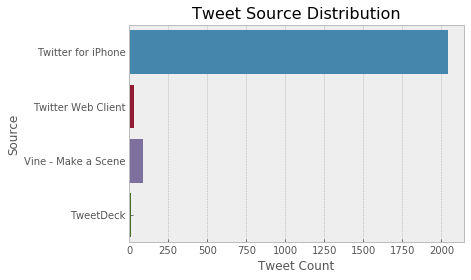

In [152]:
plt.style.use('bmh')
sns.countplot(data = archive_clean, y = 'source')
plt.title('Tweet Source Distribution', fontsize=16)
plt.xlabel('Tweet Count', fontsize=12)
plt.ylabel('Source', fontsize=12)
plt.savefig('tweet-source.png');

The Twitter app is the most widely used platform; 94% of twitter users use the mobile iPhone app to originate tweets. The other 6% use the Twitter web client (mobile and desktop), Vine, and TweetDeck.

In [153]:
archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

In [154]:
twitter_archive_dogs['rating'].value_counts()

10.0    432
12.0    309
11.0    253
13.0    183
14.0    17 
9.0     3  
5.0     1  
8.0     1  
7.0     1  
Name: rating, dtype: int64

In [155]:
# There are 17 top rated dogs
twitter_archive_dogs.sort_values(by=['rating'], ascending=False).head (17)
top_rated = twitter_archive_dogs.query('rating == 14')
top_rated.sort_values(by=['retweet_count'], ascending=False)
top_rated.sort_values(by=['favorite_count'], ascending=False)

,tweet_id,timestamp,text,rating,name,dog_stage,retweet_count,favorite_count,weekday,jpg_url,prediction_1
333,819004803107983360,2017-01-11 02:15:36,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,14.0,Bo,Doggo,39885,91816,Weds,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,Standard Poodle
297,825535076884762624,2017-01-29 02:44:34,Here's a very loving and accepting puppo. Appears to have read her Constitution well. 14/10 would pat head approvingly https://t.co/6ao80wIpV1,14.0,None,Puppo,18561,54904,Sun,https://pbs.twimg.com/media/C3TjvitXAAAI-QH.jpg,Rottweiler
64,878057613040115712,2017-06-23 01:10:23,This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,14.0,Emmy,Unknown,6654,41154,Fri,https://pbs.twimg.com/media/DC98vABUIAA97pz.jpg,French Bulldog
362,813812741911748608,2016-12-27 18:24:12,"Meet Gary, Carrie Fisher's dog. Idk what I can say about Gary that reflects the inspirational awesomeness that was Carrie Fisher. 14/10 RIP https://t.co/uBnQTNEeGg",14.0,Gary,Unknown,15270,38645,Tues,https://pbs.twimg.com/media/C0s-XtzWgAAp1W-.jpg,French Bulldog
153,854120357044912130,2017-04-17 23:52:16,Sometimes you guys remind me just how impactful a pupper can be. Cooper will be remembered as a good boy by so many. 14/10 rest easy friend https://t.co/oBL7LEJEzR,14.0,None,Pupper,7722,32499,Mon,https://pbs.twimg.com/media/C9px7jyVwAAnmwN.jpg,Black-And-Tan Coonhound
9,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,14.0,Cassie,Doggo,7184,31223,Weds,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,Pembroke
313,822462944365645825,2017-01-20 15:17:01,"This is Gabe. He was the unequivocal embodiment of a dream meme, but also one h*ck of a pupper. You will be missed by so many. 14/10 RIP https://t.co/M3hZGadUuO",14.0,Gabe,Pupper,15858,30085,Fri,https://pbs.twimg.com/media/C2n5rUUXEAIXAtv.jpg,Pomeranian
147,856282028240666624,2017-04-23 23:01:59,"This is Cermet, Paesh, and Morple. They are absolute h*ckin superstars. Watered every day so they can grow. 14/10 for all https://t.co/GUefqUmZv8",14.0,Cermet,Unknown,6472,28016,Sun,https://pbs.twimg.com/media/C-If9ZwXoAAfDX2.jpg,Chihuahua
36,884441805382717440,2017-07-10 15:58:53,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",14.0,None,Unknown,5513,26420,Mon,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,Pembroke
571,774314403806253056,2016-09-09 18:31:54,I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC BY HIS OWNER THIS IS SO WILD. 14/10 ULTIMATE LEGEND STATUS https://t.co/7oQ1wpfxIH,14.0,None,Unknown,6027,23059,Fri,https://pbs.twimg.com/media/Cr7q1VxWIAA5Nm7.jpg,Eskimo Dog


**Bo**, a Standard Poodle is clearly the overall winner with a combined rating of 14, retweet count of 39,885 and favorite count of 91,816. The retweet count and favorite counts are both the highest in this group of ratings.

In [156]:
#Top favorited dogs
twitter_archive_dogs.sort_values(by=['favorite_count'], ascending=False).head()

,tweet_id,timestamp,text,rating,name,dog_stage,retweet_count,favorite_count,weekday,jpg_url,prediction_1
309,822872901745569793,2017-01-21 18:26:02,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,None,Puppo,47439,139803,Sat,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland Terrier
400,807106840509214720,2016-12-09 06:17:20,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,Stephan,Unknown,60680,126490,Fri,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Chihuahua
108,866450705531457537,2017-05-22 00:28:40,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. 13/10 such passion, much tender https://t.co/wk7TfysWHr",13.0,Jamesy,Pupper,35263,121473,Mon,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,French Bulldog
809,739238157791694849,2016-06-04 23:31:25,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,None,Doggo,61615,120858,Sat,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,Eskimo Dog
58,879415818425184262,2017-06-26 19:07:24,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13.0,Duddles,Unknown,43240,103629,Mon,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,English Springer


The top favorited dog is a super supportive Lakeland Terrior who attended #WomensMarch.

In [157]:
#Top retweeted dogs
twitter_archive_dogs.sort_values(by=['retweet_count'], ascending=False).head(5)

,tweet_id,timestamp,text,rating,name,dog_stage,retweet_count,favorite_count,weekday,jpg_url,prediction_1
809,739238157791694849,2016-06-04 23:31:25,Here's a doggo blowing bubbles. It's downright legendary. 13/10 would watch on repeat forever (vid by Kent Duryee) https://t.co/YcXgHfp1EC,13.0,None,Doggo,61615,120858,Sat,https://pbs.twimg.com/ext_tw_video_thumb/739238016737267712/pu/img/-tLpyiuIzD5zR1et.jpg,Eskimo Dog
400,807106840509214720,2016-12-09 06:17:20,This is Stephan. He just wants to help. 13/10 such a good boy https://t.co/DkBYaCAg2d,13.0,Stephan,Unknown,60680,126490,Fri,https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg,Chihuahua
309,822872901745569793,2017-01-21 18:26:02,Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,13.0,None,Puppo,47439,139803,Sat,https://pbs.twimg.com/media/C2tugXLXgAArJO4.jpg,Lakeland Terrier
58,879415818425184262,2017-06-26 19:07:24,This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,13.0,Duddles,Unknown,43240,103629,Mon,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,English Springer
333,819004803107983360,2017-01-11 02:15:36,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,14.0,Bo,Doggo,39885,91816,Weds,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,Standard Poodle


The most retweeted dog is a Eskimo Dog with bubble blowing skills.

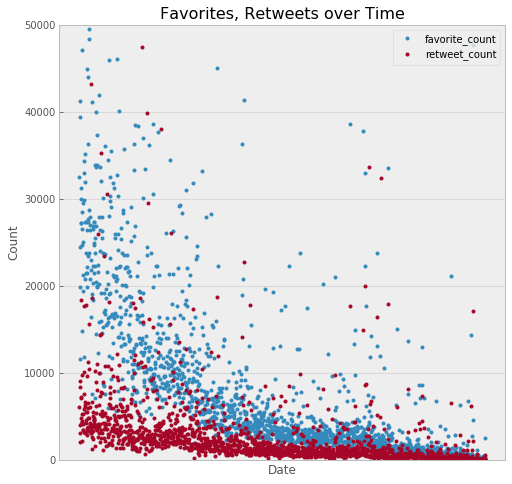

In [158]:
twitter_archive_master[['favorite_count', 'retweet_count']].plot(style ='.', ylim=[0, 50000], figsize=(8,8))
plt.title('Favorites, Retweets over Time', size=16)
plt.xlabel('Date', size=12)
plt.xticks([], [])
plt.ylabel('Count', size=12)
plt.legend(ncol=1, loc='upper right')
plt.savefig('retweets-favorites-time.png');

Favorites are more popular than retweets. Both decreasing over time, and retweets even more so.

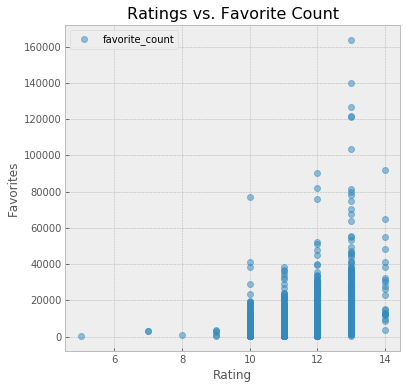

In [160]:
twitter_archive_master.plot(x = 'rating', y = 'favorite_count', style ='o', figsize=(6,6), alpha=.5)
plt.title('Ratings vs. Favorite Count', size=16)
plt.xlabel('Rating', size=12)
plt.ylabel('Favorites', size=12);

Higher rated dogs get more favorites.

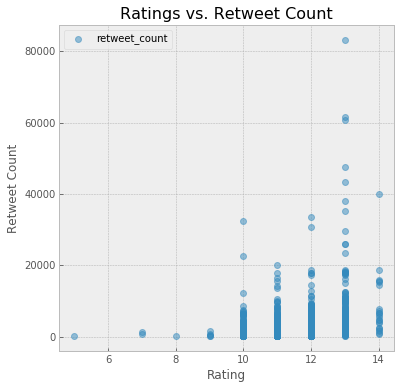

In [161]:
twitter_archive_master.plot(x = 'rating', y = 'retweet_count', style ='o', alpha=.5, figsize=(6,6));
plt.title('Ratings vs. Retweet Count', size=16)
plt.xlabel('Rating', size=12)
plt.ylabel('Retweet Count', size=12);

Higher rated dogs have more retweets.

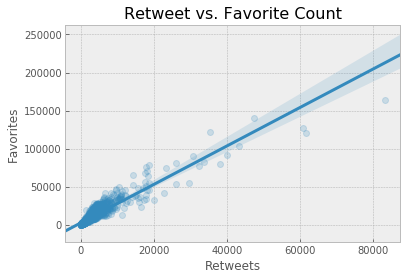

In [163]:
sns.regplot(x="retweet_count", y="favorite_count", data=twitter_archive_master, scatter_kws={'alpha':0.2})
plt.title('Retweet vs. Favorite Count', size=16)
plt.xlabel('Retweets', size=12)
plt.ylabel('Favorites', size=12)
plt.savefig('retweet-favorite.png');

There is a strong positive correlation between number of retweets and favorite count. It does seem reasonable that the more a post is retweeted, the more eyes view the post, the more favorites the post receives.

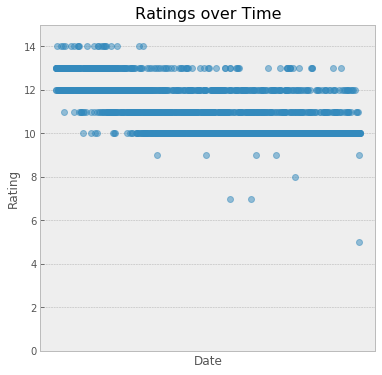

In [164]:
twitter_archive_master['rating'].plot(style = 'o', alpha=.5, figsize=(6,6), ylim=[0, 15])
plt.title('Ratings over Time', size=16)
plt.xlabel('Date')
plt.xticks([], [])
plt.ylabel('Rating');

Ratings have decreased over time.

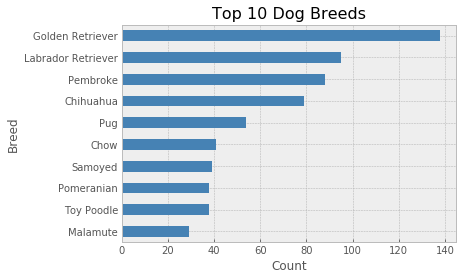

In [166]:
top_breeds = twitter_archive_master.prediction_1.value_counts()[0:10].sort_values(axis=0, ascending=True)
top_breeds.plot(kind = 'barh', color=['steelblue'])
plt.title('Top 10 Dog Breeds', size=16)
plt.xlabel('Count', size=12)
plt.ylabel('Breed', size=12)
plt.savefig('top-breeds.png');

There are more Golden Retrievers than any other dog in the dataset. Labrador Retrievers are the second most common.

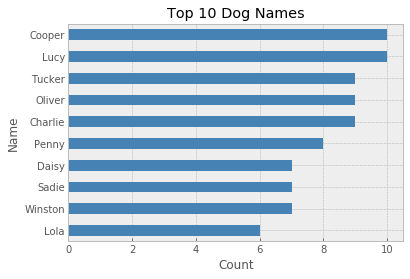

In [167]:
top_names = twitter_archive_master.name.value_counts()[1:11].sort_values (axis=0, ascending=True)
top_names.plot(kind = 'barh', color='steelblue')
plt.title('Top 10 Dog Names')
plt.xlabel('Count')
plt.ylabel('Name')
plt.savefig('top-names.png');

Cooper and Lucy are the most popular dog names. Tucker, Oliver, and Charlie follow close behind.

In [171]:
top_rated_breeds = twitter_archive_dogs.sort_values(by=['rating'], ascending=False).head(10)
top_rated_breeds.groupby('prediction_1')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
prediction_1,,,,,,,,
Bedlington Terrier,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
Black-And-Tan Coonhound,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
Chihuahua,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
Eskimo Dog,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
French Bulldog,2.0,14.0,0.0,14.0,14.0,14.0,14.0,14.0
Golden Retriever,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
Old English Sheepdog,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
Pembroke,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0
Rottweiler,1.0,14.0,NaN,14.0,14.0,14.0,14.0,14.0


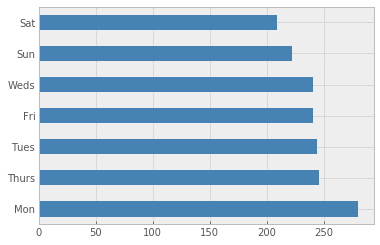

In [172]:
tweets = twitter_archive_master['weekday'].value_counts()
tweets.plot(kind = 'barh', color='steelblue')
plt.savefig('weekdays.png');

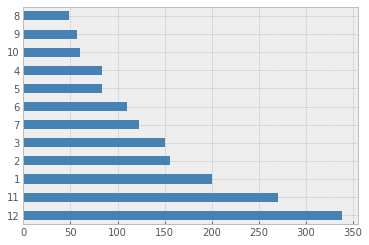

In [173]:
tweets_month = tweets = twitter_archive_master['month'].value_counts()
tweets_month.plot(kind = 'barh', color='steelblue')
plt.savefig('month-tweets.png');

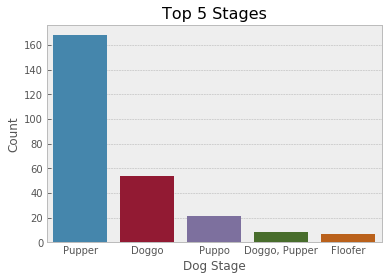

In [174]:
sorted_stage = twitter_archive_master['dog_stage'].value_counts()[1:6].index
sns.countplot(data = twitter_archive_master, x = 'dog_stage', order = sorted_stage, orient = 'h')
plt.xlabel('Dog Stage', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Top 5 Stages',fontsize=16)
plt.savefig('top-stages.png');

In [175]:
twitter_archive_master['dog_stage'].value_counts()

Unknown           1423
Pupper            168 
Doggo             54  
Puppo             21  
Doggo, Pupper     8   
Floofer           7   
Doggo, Floofer    1   
Doggo, Puppo      1   
Name: dog_stage, dtype: int64

Most dogs are classified in the 'Pupper' stage: "A pupper is a small doggo, usually younger. Can be equally, if not more mature, than most doggos. A doggo that is inexperienced, unfamiliar, or in any way unprepared for the responsibilities associated with being a doggo."

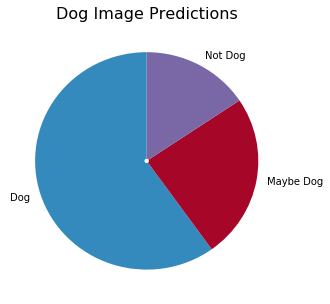

In [176]:
image_clean['prediction'].value_counts().plot(kind='pie', figsize=(5,5), startangle = 90, wedgeprops = {'width': 0.98})
plt.title('Dog Image Predictions',fontsize=16);
plt.ylabel('');

Just over half of the 'dogs' in the image dataset might actually be dogs.

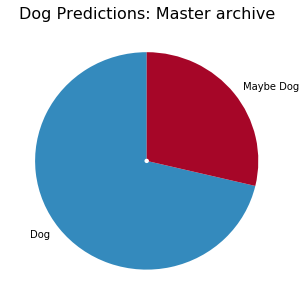

In [178]:
twitter_archive_master['prediction'].value_counts().plot(kind='pie', figsize=(5,5), startangle = 90, wedgeprops = {'width': 0.98})
plt.title('Dog Predictions: Master archive',fontsize=16);
plt.ylabel('');

Three quarters of the 'dogs' in the master archive datatbase are actually dogs.

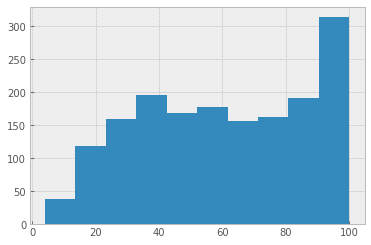

In [179]:
twitter_archive_master['p1_conf'].hist();

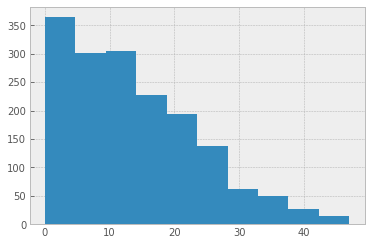

In [182]:
twitter_archive_master['p2_conf'].hist();

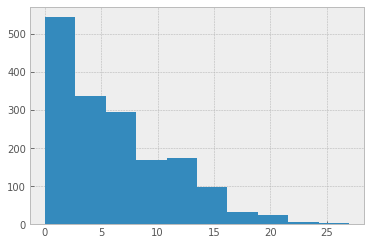

In [183]:
twitter_archive_master['p3_conf'].hist();